In [99]:
!python --version

Python 3.7.10


# Embeddings
- [gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_annoy.html?highlight=load%20word2vec%20txt#work-with-google-s-word2vec-files) - **why do I need it????**
- [tokenizer](https://github.com/google/sentencepiece/blob/master/python/README.md)


## Load data (separate dataset)
- the 2008-2016 dataset 
- python language

In [2]:
!python -c "import tensorflow as tf;print(tf.reduce_sum(tf.random.normal([1000, 1000])))"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'tensorflow'


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks 
from tensorflow.keras import optimizers, models

import sentencepiece as spm

In [2]:
!pip --version

pip 20.1.1 from /Users/alinabogdanova/.pyenv/versions/3.7.10/lib/python3.7/site-packages/pip (python 3.7)


In [3]:
df = pd.read_csv("python_solved.csv")
df = df.drop(columns=["round", "task", "solution", "file", "full_path", "Unnamed: 0.1", "Unnamed: 0", "lang"])

- Let's remove the sort files, then select users with the highest amount of files

- count lines

In [4]:
df["n_lines"] = df.flines.apply(lambda x: str(x).count("\n"))
df["n_lines"].describe()

count    76797.000000
mean        49.785148
std         81.446066
min          0.000000
25%         26.000000
50%         39.000000
75%         60.000000
max       7792.000000
Name: n_lines, dtype: float64

- let's save files with amount of lines in range `[30; 120]`

In [5]:
df = df[(df.n_lines>0)]#&(df.n_lines<=120)]
df.n_lines.describe()

count    76786.000000
mean        49.792280
std         81.449719
min          1.000000
25%         26.000000
50%         39.000000
75%         60.000000
max       7792.000000
Name: n_lines, dtype: float64

- let's find avg file length (in chars)

In [6]:
# df["n_chars"] = df.flines.apply(lambda x: len(str(x)))
# (df.n_chars/df.n_lines).describe()

- suspicious max value let's drop evetyrhing, highter then `100` and look, what's left

In [7]:
# df["chars_per_line"] = df.n_chars/df.n_lines
# df = df[df.chars_per_line<100]
# df.describe()

- less, then 100 files were removed

## Tokenization
- let's apply embedding to all the source files **LOSE LAYOUT FEATURES**
- * it takes time

Example of lib usage
```python
sp.encode('\tarr = [int(x) for x in str.split()]')
>> [6682, 14, 127, 184, 96091, 96097, 96090, 115, 419, 57, 420, 96084, 1300, 5382]
print(sp.decode(sp.encode('    arr = [int(x) for x in str.split()]')))
>> arr = [int(x) for x in str.split()]
```

In [8]:
sp = spm.SentencePieceProcessor(model_file='embd/sentencepiece_bpe.model')
df.index = np.arange(len(df))
df["n_tokens"] = df.flines.apply(lambda x: len(sp.encode(x)))
df.describe()

,year,n_lines,n_tokens
count,76786.000000,76786.000000,76786.000000
mean,2014.370080,49.792280,340.019248
std,2.464238,81.449719,743.152993
min,2008.000000,1.000000,0.000000
25%,2013.000000,26.000000,167.000000
50%,2015.000000,39.000000,249.000000
75%,2016.000000,60.000000,385.000000
max,2017.000000,7792.000000,36488.000000


- let's set the threshold of 600 tokens here

In [9]:
df = df[df.n_tokens<=600]
df.describe()

,year,n_lines,n_tokens
count,69980.000000,69980.000000,69980.000000
mean,2014.417491,40.930466,259.533138
std,2.444826,20.893534,125.327566
min,2008.000000,1.000000,0.000000
25%,2013.000000,25.000000,161.000000
50%,2015.000000,37.000000,233.000000
75%,2016.000000,53.000000,337.000000
max,2017.000000,265.000000,600.000000


- let's look at the amount of files per participant

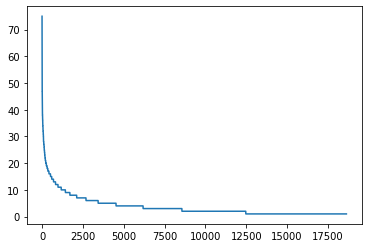

In [10]:
plt.plot(np.array(df.username.value_counts()))

- Let's collect `15` users with avg amount of files, which is around 35
(enough files, but their difference amount is not sufficient)

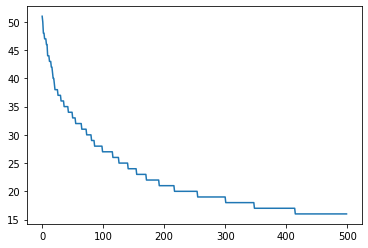

In [15]:
plt.plot(np.array(df.username.value_counts())[5:505])

In [16]:
users = df.username.value_counts()[5:505].index
df = df[df.username.isin(users)]
df.head()

,year,username,flines,n_lines,n_tokens
6,2008,zibada,import sys\n def dbg(a): sys.stderr.write(str(...,40,447
7,2008,zibada,import sys\n def dbg(a): sys.stderr.write(str(...,47,299
8,2008,zibada,import sys\n def dbg(a): sys.stderr.write(str(...,51,345
9,2008,Klinck,import sys\n input = sys.stdin\n \n def solve(...,40,313
10,2008,Klinck,import sys\n from Numeric import *\n input = s...,60,372


- Let's look at the amount of files per person in more details

In [17]:
df.username.value_counts().describe()

count    500.000000
mean      22.438000
std        7.315544
min       16.000000
25%       17.000000
50%       20.000000
75%       26.000000
max       51.000000
Name: username, dtype: float64

- Hope, this is enough and the contrast between the smallest amount and the max, won't be sufficient

In [18]:
df.username.value_counts()

lidaobing        51
zli              50
Vytis            48
kusano           48
xtof.durr        47
                 ..
GiB              16
champjss         16
timguoqk         16
bohdan.dovhan    16
Danlark          16
Name: username, Length: 500, dtype: int64

In [19]:
df["tokens"] = df.flines.apply(lambda x: sp.encode(x))

In [20]:
df.head()

,year,username,flines,n_lines,n_tokens,tokens
6,2008,zibada,import sys\n def dbg(a): sys.stderr.write(str(...,40,447,"[138, 1149, 63, 71605, 96091, 96071, 45, 1149,..."
7,2008,zibada,import sys\n def dbg(a): sys.stderr.write(str(...,47,299,"[138, 1149, 63, 71605, 96091, 96071, 45, 1149,..."
8,2008,zibada,import sys\n def dbg(a): sys.stderr.write(str(...,51,345,"[138, 1149, 63, 71605, 96091, 96071, 45, 1149,..."
9,2008,Klinck,import sys\n input = sys.stdin\n \n def solve(...,40,313,"[138, 1149, 1128, 14, 1149, 96084, 8827, 63, 1..."
10,2008,Klinck,import sys\n from Numeric import *\n input = s...,60,372,"[138, 1149, 156, 22628, 138, 250, 1128, 14, 11..."


In [21]:
dataset = df[["username", "tokens"]]

In [22]:
dataset

,username,tokens
6,zibada,"[138, 1149, 63, 71605, 96091, 96071, 45, 1149,..."
7,zibada,"[138, 1149, 63, 71605, 96091, 96071, 45, 1149,..."
8,zibada,"[138, 1149, 63, 71605, 96091, 96071, 45, 1149,..."
9,Klinck,"[138, 1149, 1128, 14, 1149, 96084, 8827, 63, 1..."
10,Klinck,"[138, 1149, 156, 22628, 138, 250, 1128, 14, 11..."
...,...,...
76758,alex1770,"[138, 1149, 156, 5045, 138, 3020, 63, 9827, 96..."
76768,jfguo,"[138, 5045, 138, 566, 138, 1149, 138, 6510, 13..."
76773,ozan,"[156, 5045, 138, 3020, 63, 7824, 96091, 5205, ..."
76774,ozan,"[63, 921, 96091, 983, 45, 85, 1574, 626, 239, ..."


## Load data
Lib selected - tensorflow + keras

### Some small notes for future
Tensorflow supports python 3.8 as max version. The issue arises on latest Ubuntu/max os-es, when the default python version is 3.9.

What was done on MAC-OS-Big-Sur to solve that issue.
- [pyenv](https://github.com/pyenv/pyenv) installed
```bash
>> brew update
>> brew install pyenv
...
```
- python 3.7 installation
```
>> brew install python@3.7
```
- pyenv added python 3.7
```
>> pyenv install 3.7.10
>> pyenv loacal 3.7.10
```
- create [myenv](https://www.tensorflow.org/install/pip#2.-create-a-virtual-environment-recommended)
```
>> python3.7 -m venv myenv
>> source myenv/bin/activate.fish
```
- solution of the final problem - **UPGRADE PIP**
- install tensorflow
```
(myenv)>> pip install --upgrade tensorflow
```

In [23]:
le = LabelEncoder()
dataset.username = le.fit_transform(dataset.username)

/Users/alinabogdanova/Documents/workspace/research/myenv/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [24]:
# shuffle dataset
dataset = dataset.sample(frac = 1) 
dataset

,username,tokens
69499,255,"[3238, 1119, 96124, 1796, 111, 14, 655, 96091,..."
11312,33,"[1945, 14, 27, 96109, 96096, 5911, 96084, 5, 9..."
40145,91,"[3074, 594, 2785, 96124, 1119, 96124, 1376, 18..."
30524,494,"[3238, 2785, 96124, 1119, 96124, 28815, 156, 2..."
37770,486,"[63, 13778, 96091, 96070, 823, 96085, 6043, 45..."
...,...,...
33035,190,"[3074, 594, 2785, 96124, 1119, 96124, 1376, 18..."
25641,182,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 9..."
42996,105,"[96, 2102, 71465, 9647, 33942, 139, 96109, 319..."
60526,184,"[138, 1149, 63, 9827, 96091, 96139, 96085, 961..."


In [25]:
def rsh(x):
    arr = np.array(x)
    arr.resize(600)
    return list(arr)

dataset.tokens = dataset.tokens.apply(rsh)

In [26]:
dataset

,username,tokens
69499,255,"[3238, 1119, 96124, 1796, 111, 14, 655, 96091,..."
11312,33,"[1945, 14, 27, 96109, 96096, 5911, 96084, 5, 9..."
40145,91,"[3074, 594, 2785, 96124, 1119, 96124, 1376, 18..."
30524,494,"[3238, 2785, 96124, 1119, 96124, 28815, 156, 2..."
37770,486,"[63, 13778, 96091, 96070, 823, 96085, 6043, 45..."
...,...,...
33035,190,"[3074, 594, 2785, 96124, 1119, 96124, 1376, 18..."
25641,182,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 9..."
42996,105,"[96, 2102, 71465, 9647, 33942, 139, 96109, 319..."
60526,184,"[138, 1149, 63, 9827, 96091, 96139, 96085, 961..."


In [27]:
X = dataset.tokens.values
X = np.array(list(X))
X.shape

(11219, 600)

In [28]:
X = X.reshape((-1, 600, 1))
y = np.array(dataset.username)

ohe = OneHotEncoder()
y = ohe.fit_transform(y.reshape(-1, 1))
y = y.toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape

(8414, 600, 1)

### Structure of the model
1. CNN:
- ks = 50 (function - level)
- ks = 10 (line2 - level)
- ks = 5 (lene - level)
2. Linear ReLU 
3. softmax 75

> important note `tanh` activation increases accuracy from 11% to 60% ontraining (50% of test accuracy)
>
> `linear` function reaches up to 61% of test accuracy

In [409]:
model = keras.Sequential()
model.add(keras.Input(shape=(600, 1)))  
model.add(layers.Conv1D(150, 10, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(15, activation="softmax"))
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_50 (Conv1D)           (None, 591, 150)          1650      
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 73, 150)           0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 10950)             0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 10950)             0         
_________________________________________________________________
dense_88 (Dense)             (None, 64)                700864    
_________________________________________________________________
dropout_65 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_89 (Dense)             (None, 15)              

In [410]:
optimizer = optimizers.Adam(0.1)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_delta=0.000001, verbouse=1)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [411]:
epochs = 100
batch_size = 20
history = model.fit(x=X_train, y=y_train, epochs = epochs, 
                    validation_data = (X_test,y_test),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=2, 
                    callbacks=[lr_schedule])

Epoch 1/100
25/25 - 1s - loss: 16370291.0000 - accuracy: 0.0830 - val_loss: 13855447.0000 - val_accuracy: 0.0867
Epoch 2/100
25/25 - 0s - loss: 14500130.0000 - accuracy: 0.1660 - val_loss: 12177003.0000 - val_accuracy: 0.1965
Epoch 3/100
25/25 - 0s - loss: 16822834.0000 - accuracy: 0.1873 - val_loss: 13396199.0000 - val_accuracy: 0.1908
Epoch 4/100
25/25 - 0s - loss: 21550338.0000 - accuracy: 0.2104 - val_loss: 21321930.0000 - val_accuracy: 0.2428
Epoch 5/100
25/25 - 0s - loss: 33869340.0000 - accuracy: 0.2645 - val_loss: 46024960.0000 - val_accuracy: 0.2197
Epoch 6/100
25/25 - 0s - loss: 51479608.0000 - accuracy: 0.3012 - val_loss: 62284712.0000 - val_accuracy: 0.3064
Epoch 7/100
25/25 - 0s - loss: 98774760.0000 - accuracy: 0.2529 - val_loss: 109576464.0000 - val_accuracy: 0.2370
Epoch 8/100
25/25 - 0s - loss: 134677456.0000 - accuracy: 0.2876 - val_loss: 152817520.0000 - val_accuracy: 0.2486
Epoch 9/100
25/25 - 0s - loss: 166066960.0000 - accuracy: 0.3398 - val_loss: 219986928.0000 -

In [29]:
def plot_training(history):
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.title("Loss")
    plt.plot(history.history['loss'], color='b', label="Training loss")
    plt.plot(history.history['val_loss'], color='r', label="validation loss")
    plt.legend(loc='best', shadow=True)

    plt.subplot(122)
    plt.title("Accuracy")
    plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
    plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    plt.legend(loc='best', shadow=True)
    return fig

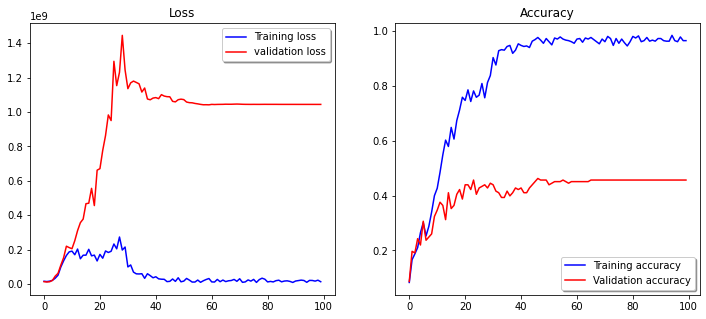

In [413]:
f = plot_training(history)

#### 64% test accuracy

```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(100, 32, activation="linear"))
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### up to 76% test accuracy
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(100, 16, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### converges to 76% test accuracy
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(100, 8, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 77% of test accuracy
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1))) 
model.add(layers.Conv1D(150, 8, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=6))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### confident 81%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(128, 16, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### up to 81.71%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1))) 
model.add(layers.Conv1D(128, 16, activation="linear", strides=2)) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### converges to 80%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))  
model.add(layers.Conv1D(150, 10, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

- Also the structures with 2 Convolutional layers were tested (up to 50% accuracy)
- Avg Pooling works poarly due to the fact, that the initial data is not normalized

In [30]:
from sklearn.metrics import confusion_matrix
import itertools

def plt_conf_matrix(cm, classes):
    cmap=plt.cm.Blues
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
     

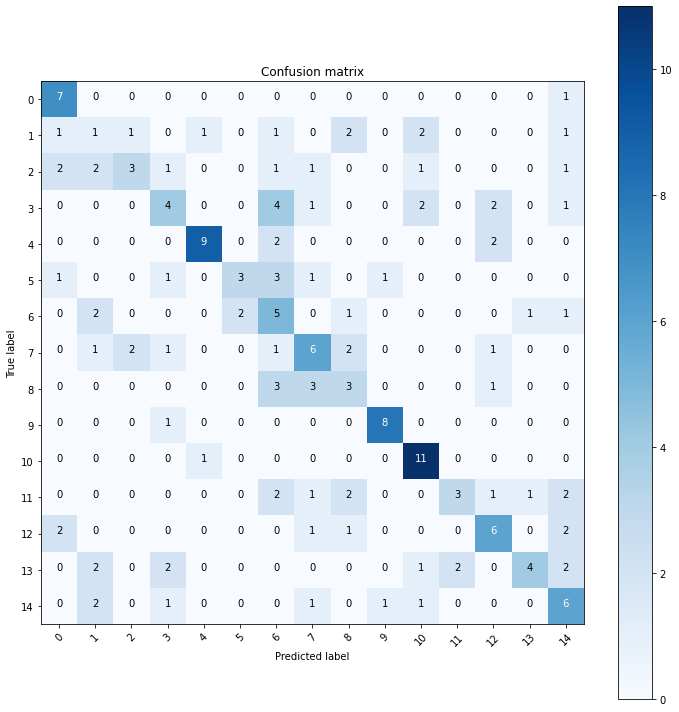

In [415]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plt_conf_matrix(confusion_mtx, classes = range(15))

In [56]:
model.save('model.h5')

I don't know, what are these ebbeddings, but...

## Let's apply normalization
(thus `relu`, `than` and other activations may be used)

In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
print(X.min(), X.mean(), X.max())

0 12801.809572005823 99756


As it can be seen, the avg value is far from it's maximum value, thus it is more readonable to apply Standard Scaling

In [33]:
ss = StandardScaler()
X = X.reshape((-1, 600))
X = ss.fit_transform(X)
X = X.reshape((-1, 600, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape

(8414, 600, 1)

In [419]:
model = keras.Sequential()
model.add(keras.Input(shape=(600, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Conv1D(32, 4, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(15, activation="softmax"))
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_51 (Conv1D)           (None, 585, 64)           1088      
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 73, 64)            0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 70, 32)            8224      
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 8, 32)             0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 256)               0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 64)              

In [420]:
optimizer = optimizers.Adam(0.01)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_delta=0.000001, verbouse=1)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [421]:
epochs = 100
batch_size = 20
history = model.fit(x=X_train, y=y_train, epochs = epochs, 
                    validation_data = (X_test,y_test),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=2, 
                    callbacks=[lr_schedule])

Epoch 1/100
25/25 - 1s - loss: 3.2958 - accuracy: 0.0849 - val_loss: 2.7181 - val_accuracy: 0.0809
Epoch 2/100
25/25 - 1s - loss: 2.8095 - accuracy: 0.1197 - val_loss: 2.5354 - val_accuracy: 0.2023
Epoch 3/100
25/25 - 0s - loss: 2.5665 - accuracy: 0.1757 - val_loss: 2.6315 - val_accuracy: 0.1734
Epoch 4/100
25/25 - 0s - loss: 2.5215 - accuracy: 0.1892 - val_loss: 2.4069 - val_accuracy: 0.2254
Epoch 5/100
25/25 - 0s - loss: 2.4757 - accuracy: 0.2278 - val_loss: 2.7365 - val_accuracy: 0.1850
Epoch 6/100
25/25 - 0s - loss: 2.5372 - accuracy: 0.2085 - val_loss: 2.3050 - val_accuracy: 0.2659
Epoch 7/100
25/25 - 0s - loss: 2.4569 - accuracy: 0.2452 - val_loss: 2.3077 - val_accuracy: 0.2717
Epoch 8/100
25/25 - 0s - loss: 2.3370 - accuracy: 0.2722 - val_loss: 2.4233 - val_accuracy: 0.2312
Epoch 9/100
25/25 - 0s - loss: 2.2520 - accuracy: 0.2896 - val_loss: 2.3786 - val_accuracy: 0.2659
Epoch 10/100
25/25 - 0s - loss: 2.2701 - accuracy: 0.3012 - val_loss: 2.5001 - val_accuracy: 0.2428
Epoch 11/

#### 80% accuracy (previous model)
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(150, 10, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 82%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(128, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 86% up to 87%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Conv1D(32, 4, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 84%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Conv1D(32, 4, activation="linear")) 
model.add(layers.MaxPooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```
#### 84%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(64, 16, activation="tanh"))
model.add(layers.AveragePooling1D(pool_size=8))
model.add(layers.Conv1D(32, 8, activation="linear")) 
model.add(layers.AveragePooling1D(pool_size=4))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

#### 83%
```python
model = keras.Sequential()
model.add(keras.Input(shape=(500, 1)))
model.add(layers.Conv1D(128, 16, activation="relu"))
model.add(layers.MaxPooling1D(pool_size=8))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
model.summary()
```

In [87]:
model.save('86_model.h5')

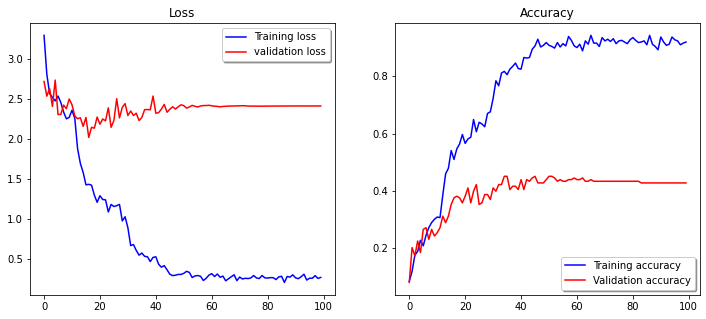

In [422]:
f = plot_training(history)

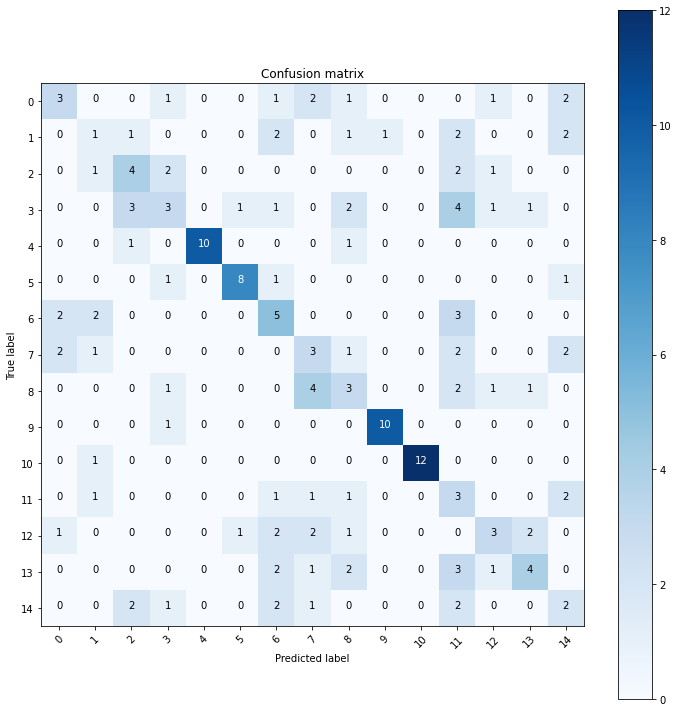

In [423]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
plt_conf_matrix(confusion_mtx, classes = range(15))

## Triplet loss
- useful [link1](https://zhangruochi.com/Create-a-Siamese-Network-with-Triplet-Loss-in-Keras/2020/08/11/ ), [link2](https://codepad.co/snippet/triplet-loss-in-keras-tensorflow-backend)

### Main idea (If I understood correctly)
- create embedding for embeddings (?)
- apply KNN to find the closest vectors - if the problem is related to the classification

### Data preprocessing flow:
1. Split X[-1, 500] on pices of [-1, 100] and increase the dimensionality of array
2. Shuffle ???
3. Create batch_loader:
        3.1. Select anchor samples (**TODO** search if it is usually done sequentially or randomly)
        3.2. Select some X, where y is the same (random or sequential???)
        3.3. Select some X, where y is different (random or sequential???)
4. Create model (e.g. Sequential)
5. Concatenate 3 models for anchor, positives an negatives // this is exactly the parallel convolution, which I was searching during the previous stages
6. Create a functions `loss` and `data_generator`
7. Train model with dummy y (e.g 0) ([good example](https://github.com/AdrianUng/keras-triplet-loss-mnist#visualizing-separation-of-classes ), [their code](https://github.com/AdrianUng/keras-triplet-loss-mnist/blob/master/Triplet_loss_KERAS_semi_hard_from_TF.ipynb))
8. Apply the visualization with PCA/test on KNN????

### Make samples smaller, e.g. 100
- potential problem - files are ended with zeros, if amount of tokens is less


In [102]:
!/Users/alinabogdanova/.pyenv/versions/3.7.10/bin/python3.7 -m pip install --upgrade pip

  Using cached pip-21.0.1-py3-none-any.whl (1.5 MB)
  Attempting uninstall: pip
    Found existing installation: pip 20.1.1
    Uninstalling pip-20.1.1:
      Successfully uninstalled pip-20.1.1


In [103]:
!pip install -q -U tensorflow-addons

In [104]:
import tensorflow_addons as tfa

In [34]:
def crop_to(X, y, crop=100, threshold=80):
    new_X = []
    new_y = []
    for old_x, old_y in zip(X, y):
        for el in old_x.reshape(-1, 100):
            if(np.count_nonzero(el) > 80):
                new_X.append(list(el))
                new_y.append(np.argmax(old_y))
    
    new_X = np.array(new_X).reshape(-1, crop, 1)
    new_y = np.array(new_y)
    return new_X, new_y

# new_X, new_y = crop_to(X, y)
new_X, new_y = X, np.argmax(y, axis=1)

In [35]:
new_X.shape

(11219, 600, 1)

In [36]:
data_length = new_y.shape[0]

### Shuffle - do I need this?
- No, because in the batch I'm going to use random

### Batch generation

In [37]:
def batch_generator(X, y):
    
    data_length = X.shape[0]
    index = np.random.randint(data_length)
    anchor, anchor_y = X[index], y[index]
    
    positive = X[np.random.choice(np.where(y==anchor_y)[0])]
    negative = X[np.random.choice(np.where(y!=anchor_y)[0])]
    
    return [list(anchor), list(positive), list(negative)]

def batches_generator(X, y, batch_size=32):
    '''
    Array of batch_generator results
    
    batch_size - size of the generated array
    '''
    all_data = np.array([batch_generator(X, y) for i in range(batch_size)])
    anchors = all_data[:, 0, :]
    positives = all_data[:, 1, :]
    negatives = all_data[:, 2, :]
    return anchors, positives, negatives

def data_generator(X, y, batch_size=32, input_size=600):
    while True:
        batch = batches_generator(X, y, batch_size)
        labels = np.zeros((batch_size, input_size*3)) 
        yield batch, labels
        


### Model creation


- let's repeat the best arch

In [38]:
import tensorflow as tf
from tensorflow.keras import regularizers


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [39]:
params = {
    "activations" : ["tanh", "relu", "elu", "sigmoid", "linear", "selu", "gelu", "swish"],
    #"output_sizes" : [50, 100, 500],
    "L2_lambda": [0.01, 0.001, 0.0001],
    "pool_1_size": [4, 8],
    "pool_2_size":[4, 8],
    "conv_1_size": [16, 32, 64],
    "conv_2_size":[4, 8],
    "dense_1": [64]   
}
params = {
    "activations" : ["relu"],
    #"output_sizes" : [50, 100, 500],
    "L2_lambda": [0.001],
    "pool_1_size": [4, 8],
    "pool_2_size":[4, 8],
    "conv_1_size": [8, 16],
    "conv_2_size":[4, 8],
    "dense_1": [64]   
}

In [40]:
new_X.shape, new_y.shape

((11219, 600, 1), (11219,))

In [41]:
output_size = 50
input_size = 600

In [42]:
def create_model(activation="linear", L2_lambda=0.02, 
                 pool_1_size=4, pool_2_size=4, 
                 conv_1_size=16, conv_2_size=4, dense_1=64):
    
    model_core = keras.Sequential()
    model_core.add(layers.Conv1D(64, conv_1_size, 
                                 activation=activation, 
                                 kernel_regularizer=regularizers.L2(L2_lambda)))
    
    model_core.add(layers.LayerNormalization(axis=1))
    model_core.add(layers.MaxPooling1D(pool_size=pool_1_size))
    
    model_core.add(layers.Conv1D(32, conv_2_size, 
                                 activation=activation, 
                                 kernel_regularizer=regularizers.L2(L2_lambda)))

    model_core.add(layers.LayerNormalization(axis=1))
    model_core.add(layers.MaxPooling1D(pool_size=pool_2_size))
    
    model_core.add(layers.Flatten())
    model_core.add(layers.Dropout(0.5))
    model_core.add(layers.Dense(dense_1, activation=activation, 
                                kernel_regularizer=regularizers.L2(L2_lambda)))
    model_core.add(layers.LayerNormalization(axis=1))
    
    model_core.add(layers.Dropout(0.5))
    model_core.add(layers.Dense(output_size, activation=activation, 
                                kernel_regularizer=regularizers.L2(L2_lambda)))
    model_core.add(layers.LayerNormalization(axis=1))
    return model_core


In [43]:
def triplet_loss(y_true, y_pred):
    alpha = 0.2
    y_pred = tf.convert_to_tensor(y_pred)
    global output_size
    anchor = y_pred[:, :output_size]
    positive = y_pred[:, output_size:2*output_size]
    negative = y_pred[:, 2*output_size:]
    
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)

    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

In [44]:
def create_triplet_model(input_size, model_core):
    
    input_anchor = layers.Input(shape=(input_size, 1))
    input_positive = layers.Input(shape=(input_size, 1))
    input_negative = layers.Input(shape=(input_size, 1))

    model_anchor = model_core(input_anchor)
    model_positive = model_core(input_positive)
    model_negative = model_core(input_negative)

    result = layers.concatenate([model_anchor, model_positive, model_negative], axis=1)
    model = models.Model([input_anchor, input_positive, input_negative], result)
    return model


In [45]:
def train(new_X, new_y, input_size, model):
    batch_size = 64
    epochs = 100
    steps_per_epoch = int(new_X.shape[0]/batch_size)

    optimizer = optimizers.Adam(0.1)
    lr_schedule = callbacks.ReduceLROnPlateau(monitor='loss', actor=0.5, patience=2, min_delta=0.000001, verbouse=1)
    early_stopping = callbacks.EarlyStopping(monitor="loss", min_delta = 0.0001, patience=5, restore_best_weights=True)

    model.compile(loss=triplet_loss, optimizer=optimizer)
    history = model.fit(data_generator(new_X, new_y, batch_size, input_size),
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs, 
                        verbose=0, 
                        callbacks=[lr_schedule, early_stopping])
    return model, history


In [46]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [47]:
def test(model_core, new_X, new_y):
    transformed_X = model_core.predict(new_X.reshape(-1, input_size, 1))
    X_train, X_test, y_train, y_test = train_test_split(transformed_X, new_y)
    
   
    knn = KNeighborsClassifier(n_neighbors=3, algorithm="ball_tree", weights="distance")
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
    
    return score

In [48]:
param_list = []
for key in params.keys():
    if len(param_list)==0:
        for x in params[key]:
            param_list.append([x])
    else:
        new_param_list = []
        for l in param_list:
            for x in params[key]:
                l_copy = l.copy()
                l_copy.append(x)
                new_param_list.append(l_copy)
        param_list = new_param_list
len(param_list)

16

In [49]:
param_list[0]

['relu', 0.001, 4, 4, 8, 4, 64]

In [50]:
import tqdm

In [51]:
max_score = 0
best_model = None
log = []
core_model = None
for p in tqdm.tqdm(param_list[3:5]):
    core_model = create_model(*p)
    triplet = create_triplet_model(input_size, core_model)
    model, history = train(new_X, new_y, input_size, triplet)
    score = test(core_model, new_X, new_y)
    if score > max_score:
        max_score = score
        best_model = model
        print(p, score)
    log.append({"score": score, "history": history, "params": p})


 50%|█████     | 1/2 [08:56<08:56, 536.72s/it]

['relu', 0.001, 4, 4, 16, 8, 64] 0.006773618538324421


100%|██████████| 2/2 [14:30<00:00, 435.18s/it]

['relu', 0.001, 4, 8, 8, 4, 64] 0.034224598930481284


In [53]:
print(len(log))

2


In [54]:
log_df = pd.DataFrame(log)

In [55]:
log_df

,score,history,params
0,0.006774,<tensorflow.python.keras.callbacks.History obj...,"[relu, 0.001, 4, 4, 16, 8, 64]"
1,0.034225,<tensorflow.python.keras.callbacks.History obj...,"[relu, 0.001, 4, 8, 8, 4, 64]"


In [56]:
log_df["history_arr"] = log_df.history.apply(lambda x: x.history["loss"])

In [57]:
log_df["activations"] = log_df.params.apply(lambda x:x[0])
log_df["L2_lambda"]  = log_df.params.apply(lambda x:x[1])
log_df[ "pool_1_size"] = log_df.params.apply(lambda x:x[2])
log_df[ "pool_2_size"] = log_df.params.apply(lambda x:x[3])
log_df["conv_1_size"] = log_df.params.apply(lambda x:x[4])
log_df["conv_2_size"] = log_df.params.apply(lambda x:x[5])
log_df["dense_1"] = log_df.params.apply(lambda x:x[6])

In [58]:
log_df = log_df.drop(columns=["history", "params"])

In [59]:
log_df.score.describe()

count    2.000000
mean     0.020499
std      0.019411
min      0.006774
25%      0.013636
50%      0.020499
75%      0.027362
max      0.034225
Name: score, dtype: float64

#### All the tame accuracy was approximately the same

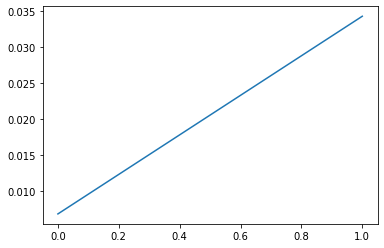

In [60]:
plt.plot(log_df.score)

### How the best model was trained?

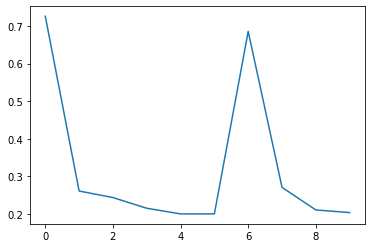

In [65]:
plt.plot(log_df.history_arr[1])

In [333]:
log_df.to_csv("grid_6.csv")

In [334]:
log_df.to_json("grid_6.json")# arrays could be exported better (history)

-  52% - 20-40 by amount of files, 600 input - 100 output
-  53% - 20-40 by amount of files, 600 input - 200 output
-  53% - 20-40 by amount of files, 600 input - 400 output
- 33% - 20-40 by amount of files, 100 input - 100 output
-  49.7% - 0-40 by amount of files, 600 input - 100 output

### Read more
- [implementation by tensorflow](https://www.tensorflow.org/addons/tutorials/losses_triplet)

## What's going on!?
Why the accuracy is so low! Let's look at the PCA of the daataset

In [66]:
import numpy as np
from sklearn.decomposition import PCA

In [67]:
# pass the data through the model

In [68]:
vectorized_X = core_model.predict(new_X)

pca = PCA(n_components=3)

pca.fit(vectorized_X)

pca_x = pca.transform(vectorized_X)

y1d = new_y
# y1d = np.argmax(new_y, axis=1)

pca_x[np.where(y1d==0), 0]

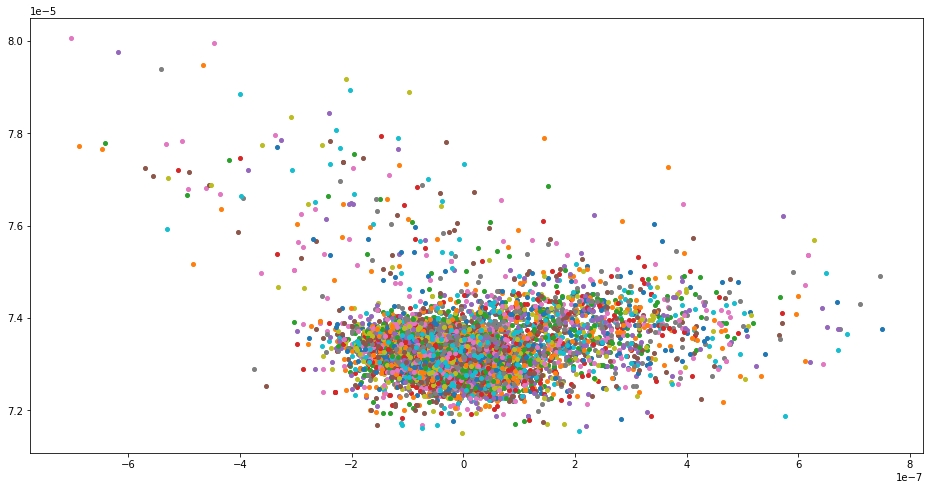

In [83]:
plt.figure(figsize=(16, 8))
for i in range(500):
    plt.plot(pca_x[np.where(y1d==i), 2][0], pca_x[np.where(y1d==i), 0][0], 'o', ms=4)# label=str(i))
# plt.legend(ncol=4)

Before
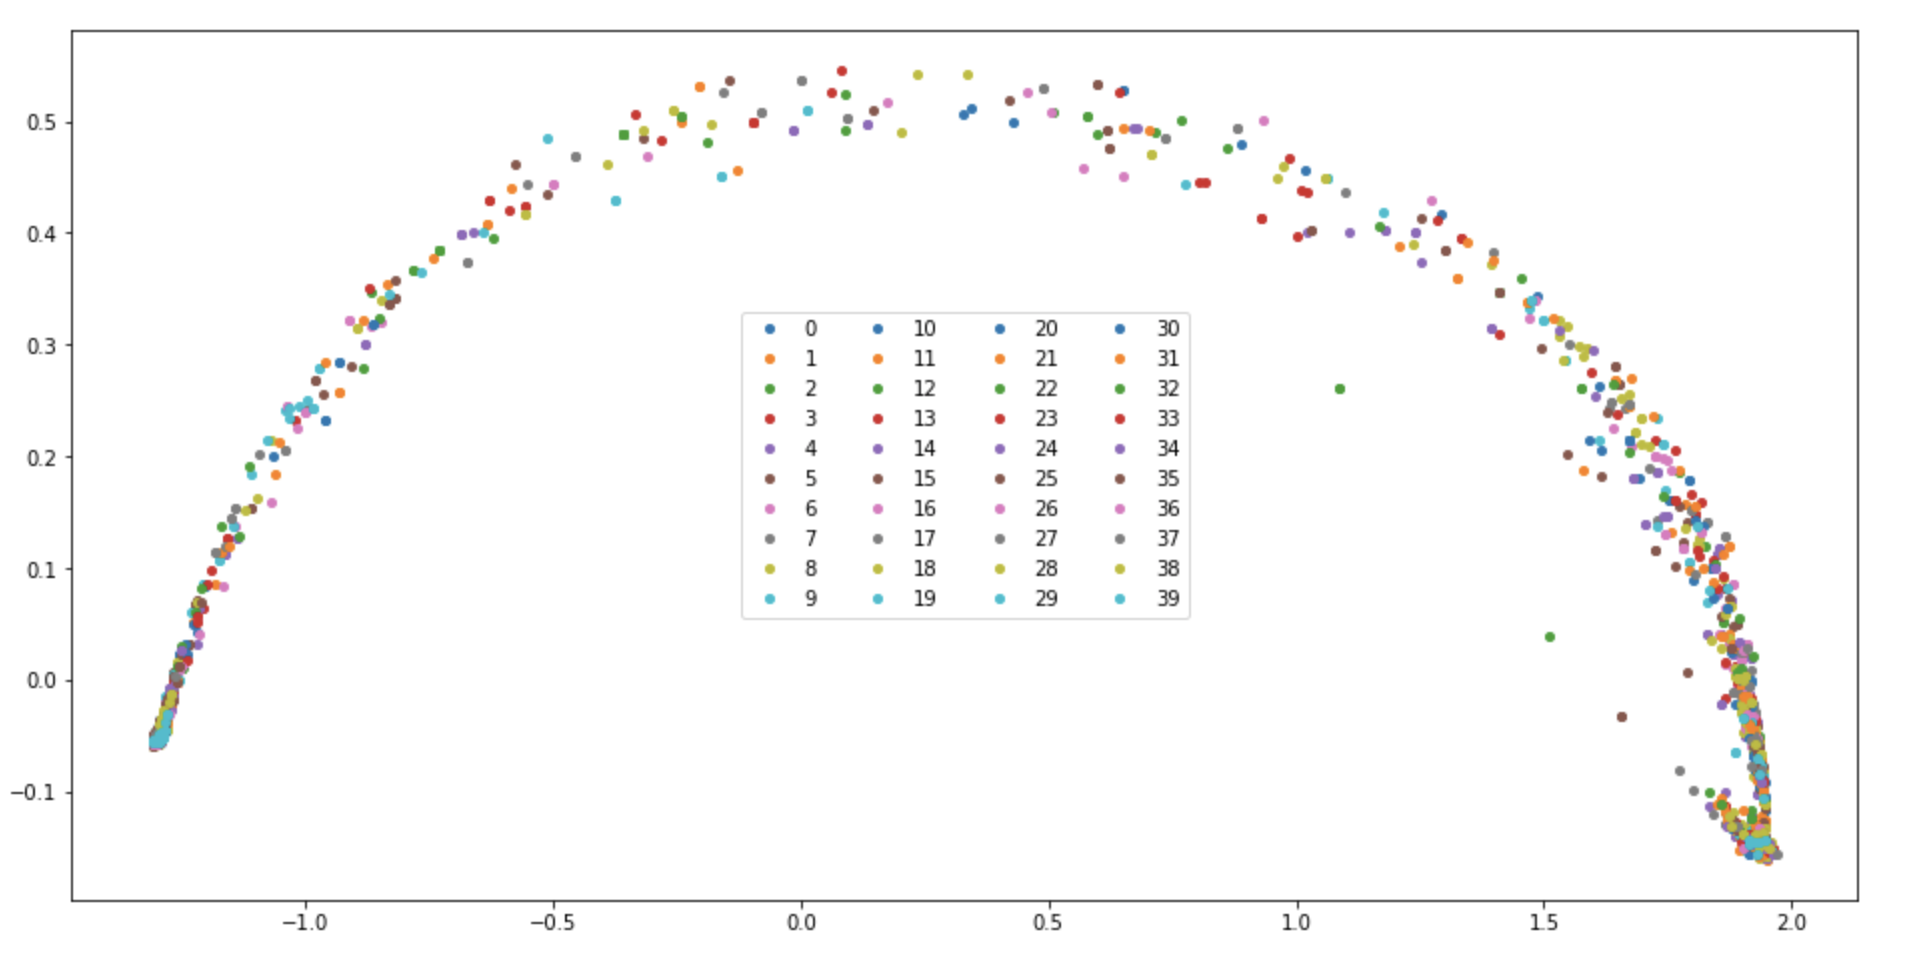

### Ok... Let's train the model on the top of the embeddings

In [463]:
new_y
ohe = OneHotEncoder()
new_y = ohe.fit_transform(new_y.reshape(-1, 1))
new_y = new_y.toarray()

In [464]:
classifier = keras.Sequential()
classifier.add(layers.Input((1, 50)))
classifier.add(layers.Dense(128, activation="linear"))
classifier.add(layers.LayerNormalization(axis=1))
classifier.add(layers.Dropout(0.5))
classifier.add(layers.Dense(64, activation="linear"))
classifier.add(layers.LayerNormalization(axis=1))
classifier.add(layers.Dropout(0.5))
classifier.add(layers.Dense(15, activation="softmax"))

In [465]:
vectorized_X.shape

(691, 50)

In [466]:
new_y.shape

(691, 15)

In [467]:
batch_size = 64
epochs = 100
steps_per_epoch = int(vectorized_X.shape[0]/batch_size)

optimizer = optimizers.Adam(0.1)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='loss', actor=0.5, patience=2, min_delta=0.000001, verbouse=1)
early_stopping = callbacks.EarlyStopping(monitor="loss", min_delta = 0.0001, patience=5, restore_best_weights=True)


classifier.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])
history = classifier.fit(x=vectorized_X, y=new_y, epochs = epochs, 
                        validation_data = (vectorized_X,new_y),
                        steps_per_epoch=vectorized_X.shape[0] // batch_size,
                        verbose=2, 
                        callbacks=[lr_schedule, early_stopping])

Epoch 1/100
10/10 - 1s - loss: 3.8103 - accuracy: 0.0695 - val_loss: 2.7178 - val_accuracy: 0.0724
Epoch 2/100
10/10 - 0s - loss: 2.9413 - accuracy: 0.0622 - val_loss: 2.7509 - val_accuracy: 0.0637
Epoch 3/100
10/10 - 0s - loss: 2.7728 - accuracy: 0.0666 - val_loss: 2.7324 - val_accuracy: 0.0666
Epoch 4/100
10/10 - 0s - loss: 2.7406 - accuracy: 0.0680 - val_loss: 2.7671 - val_accuracy: 0.0680
Epoch 5/100
10/10 - 0s - loss: 2.7376 - accuracy: 0.0767 - val_loss: 2.7200 - val_accuracy: 0.1114
Epoch 6/100
10/10 - 0s - loss: 2.7292 - accuracy: 0.0781 - val_loss: 2.7122 - val_accuracy: 0.0680
Epoch 7/100
10/10 - 0s - loss: 2.7178 - accuracy: 0.0666 - val_loss: 2.7248 - val_accuracy: 0.0666
Epoch 8/100
10/10 - 0s - loss: 2.7271 - accuracy: 0.0709 - val_loss: 2.7168 - val_accuracy: 0.0680
Epoch 9/100
10/10 - 0s - loss: 2.7238 - accuracy: 0.0651 - val_loss: 2.7077 - val_accuracy: 0.0695
Epoch 10/100
10/10 - 0s - loss: 2.7100 - accuracy: 0.0724 - val_loss: 2.7071 - val_accuracy: 0.0695
Epoch 11/

- [x] Plot data with PCA
- [x] Train more sophisticated classifier
- [x] Classification of the other question
- [x] Change the data selection process
- [ ] Look at the data with errors - nope... too much encodings and normalizations to transform it back
- [ ] Change the generation process of the triplets
- [ ] Parallell training
- [ ] Start conv2d embeddings

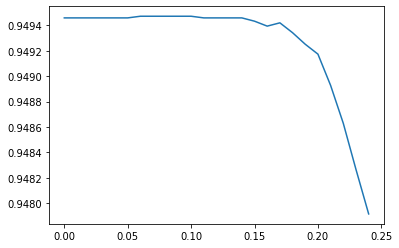

In [94]:
def test(model_core, new_X, new_y, threshold=0.2, printing=0):
    transformed_X = model_core.predict(new_X.reshape(-1, input_size, 1))
#     X_train, X_test, y_train, y_test = train_test_split(transformed_X, new_y)
    index = np.where(new_y<20)[0]
    X_test, y_test = new_X[index], new_y[index]
    y_pred = []
    y_true = []
    for i in range(X_test.shape[0]):
        for j in range(i, X_test.shape[0]):
            if np.mean((X_test[i] - X_test[j])**2) <= threshold:
                y_pred.append(1)
            else:
                y_pred.append(0)
            
            if y_test[i] == y_test[j]:
                y_true.append(1)
            else:
                y_true.append(0)
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    score = accuracy_score(y_true, y_pred)
    if printing:
        print(confusion_matrix(y_true, y_pred))
        print("totoal predicted as 1:", sum(y_pred), 
              "\ntotoal real 1:", sum(y_true), 
              "\ntotal examples", y_true.shape)
    
    return score
    

scores = [test(core_model, new_X, new_y, k) for k in np.arange(0, 0.25, 0.01) ]
plt.plot(np.arange(0, 0.25, 0.01), scores)

In [95]:
scores[-5]

0.9491743262190372

In [96]:
test(core_model, new_X, new_y, 0.2, 1)

[[72696    39]
 [ 3876   417]]
456 4293 (77028,)


0.9491743262190372

In [98]:
# Accuracy in terms of positives (recall): 
417/4293

0.09713487071977638

In [365]:
## As it can be seen, the accuracy is still around 50% in the best meaningfull cases 
## Despite the low values on KNN, threshold approximation works good (even a bit better)
## when there is a lot of data, the usual pre

Some more links
- signature recognition with [triplet loss](https://github.com/jadevaibhav/Signature-verification-using-deep-learning/blob/master/mycode.ipynb)
- 

Whhen the dataset changed, the accuracy dropped drammatically, however, the visualization performed better

### Model from TF 

In [152]:

tfa_model = create_model(activation="relu", L2_lambda=0.001, pool_1_size=4, 
                         pool_2_size=4, conv_1_size=8, conv_2_size=8, dense_1=64)
tfa_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.1),
    loss=tfa.losses.TripletSemiHardLoss(margin=0.2)
)

In [153]:
batch_size = 128
epochs = 100
steps_per_epoch = int(new_X.shape[0]/batch_size)

lr_schedule = callbacks.ReduceLROnPlateau(monitor='loss', actor=0.5, patience=2, min_delta=0.000001, verbouse=1)
early_stopping = callbacks.EarlyStopping(monitor="loss", min_delta = 0.0001, patience=7, restore_best_weights=True)


history = tfa_model.fit(x=new_X, y=new_y, epochs = epochs, 
                         validation_data = (new_X, new_y),
                         steps_per_epoch=steps_per_epoch,
                         verbose=1, 
                         callbacks=[lr_schedule, early_stopping])

Epoch 1/100
87/87 [==============================] - 21s 224ms/step - loss: 8.7459 - val_loss: nan
Epoch 2/100
87/87 [==============================] - 19s 213ms/step - loss: 3.6984 - val_loss: nan
Epoch 3/100
87/87 [==============================] - 18s 209ms/step - loss: 3.0358 - val_loss: nan
Epoch 4/100
87/87 [==============================] - 18s 211ms/step - loss: 3.2832 - val_loss: nan
Epoch 5/100
87/87 [==============================] - 18s 210ms/step - loss: 3.5835 - val_loss: nan
Epoch 6/100
87/87 [==============================] - 19s 213ms/step - loss: 7.6189 - val_loss: nan
Epoch 7/100
87/87 [==============================] - 19s 217ms/step - loss: 5.4512 - val_loss: nan
Epoch 8/100
87/87 [==============================] - 19s 219ms/step - loss: 3.9047 - val_loss: nan
Epoch 9/100
87/87 [==============================] - 19s 216ms/step - loss: 3.3085 - val_loss: nan
Epoch 10/100
87/87 [==============================] - 19s 216ms/step - loss: 3.2371 - val_loss: nan
Epoch 11/

In [159]:
# a bit more
history = tfa_model.fit(x=new_X, y=new_y, epochs = epochs, 
                         validation_data = (new_X, new_y),
                         steps_per_epoch=steps_per_epoch,
                         verbose=1, 
                         callbacks=[lr_schedule, early_stopping])

Epoch 1/100
87/87 [==============================] - 22s 260ms/step - loss: 0.7469 - val_loss: nan
Epoch 2/100
87/87 [==============================] - 21s 241ms/step - loss: 0.7443 - val_loss: nan
Epoch 3/100
87/87 [==============================] - 21s 236ms/step - loss: 0.7432 - val_loss: nan
Epoch 4/100
87/87 [==============================] - 19s 213ms/step - loss: 0.7410 - val_loss: nan
Epoch 5/100
87/87 [==============================] - 18s 208ms/step - loss: 0.7447 - val_loss: nan
Epoch 6/100
87/87 [==============================] - 18s 211ms/step - loss: 0.7392 - val_loss: nan
Epoch 7/100
87/87 [==============================] - 19s 214ms/step - loss: 0.7328 - val_loss: nan
Epoch 8/100
87/87 [==============================] - 22s 251ms/step - loss: 0.7348 - val_loss: nan
Epoch 9/100
87/87 [==============================] - 18s 213ms/step - loss: 0.7319 - val_loss: nan
Epoch 10/100
87/87 [==============================] - 18s 210ms/step - loss: 0.7309 - val_loss: nan
Epoch 11/

In [160]:
def test(model, new_X, new_y, threshold=0.2, printing=0):
    transformed_X = model.predict(new_X.reshape(-1, input_size, 1))
#     X_train, X_test, y_train, y_test = train_test_split(transformed_X, new_y)
    index = np.where(new_y<25)[0]
    X_test, y_test = new_X[index], new_y[index]
    y_pred = []
    y_true = []
    for i in range(X_test.shape[0]):
        for j in range(i, X_test.shape[0]):
            if np.mean((transformed_X[i] - transformed_X[j])**2) <= threshold:
                y_pred.append(1)
            else:
                y_pred.append(0)
            
            if y_test[i] == y_test[j]:
                y_true.append(1)
            else:
                y_true.append(0)
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    score = accuracy_score(y_true, y_pred)
    if printing:
        print(confusion_matrix(y_true, y_pred))
        print("totoal predicted as 1:", sum(y_pred), 
              "\ntotoal real 1:", sum(y_true), 
              "\ntotal examples", y_true.shape)
    
    return score
    

In [161]:
test(tfa_model, new_X, new_y, 0.2, 1)

[[75079 44965]
 [ 3197  2510]]
totoal predicted as 1: 47475 
totoal real 1: 5707 
total examples (125751,)


0.6170050337571868

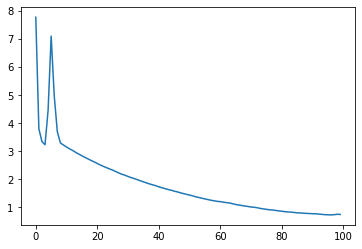

In [156]:
plt.plot(history.history['loss'])

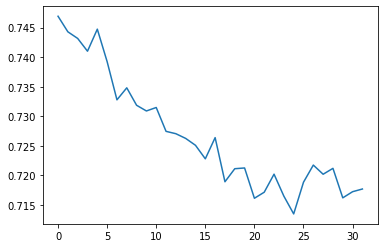

In [162]:
plt.plot(history.history['loss'])

In [163]:
vectorized_X = tfa_model.predict(new_X)

pca = PCA(n_components=3)

pca.fit(vectorized_X)

pca_x = pca.transform(vectorized_X)

y1d = new_y
# y1d = np.argmax(new_y, axis=1)

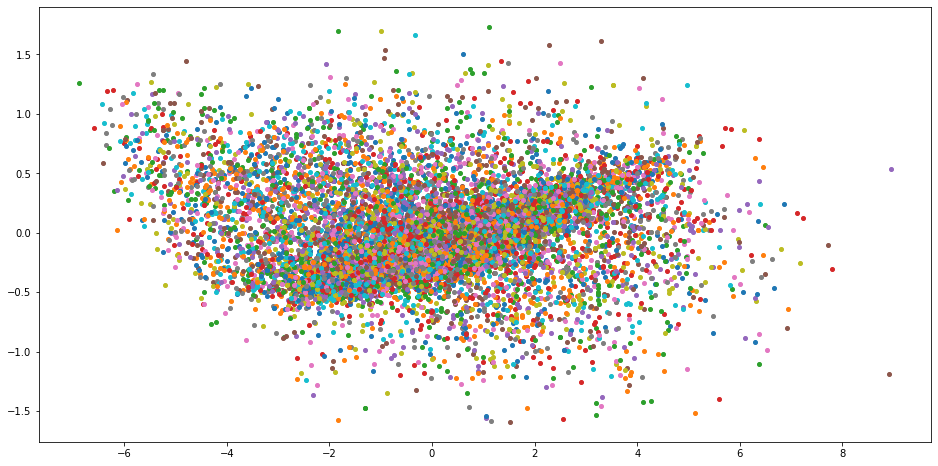

In [166]:
plt.figure(figsize=(16, 8))
for i in range(500):
    plt.plot(pca_x[np.where(y1d==i), 1][0], pca_x[np.where(y1d==i), 2][0], 'o', ms=4)# label=str(i))
# plt.legend(ncol=4)